Starting GUI...


/var/folders/06/pv5df75j61b5bgvcl8fv6k_40000gn/T/ipykernel_73492/3962003227.py:158: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = animation.FuncAnimation(fig, update, init_func=init, blit=True, interval=50)


1/1 [==============================] - 0s 250ms/step
10
1/1 [==============================] - 0s 18ms/step
10
1/1 [==============================] - 0s 21ms/step
10
1/1 [==============================] - 0s 17ms/step
10
1/1 [==============================] - 0s 19ms/step
10
1/1 [==============================] - 0s 17ms/step
1
1/1 [==============================] - 0s 18ms/step
1
1/1 [==============================] - 0s 18ms/step
1
1/1 [==============================] - 0s 18ms/step
2
1/1 [==============================] - 0s 18ms/step
2
1/1 [==============================] - 0s 18ms/step
2
1/1 [==============================] - 0s 18ms/step
3
1/1 [==============================] - 0s 18ms/step
3
1/1 [==============================] - 0s 18ms/step
3
1/1 [==============================] - 0s 18ms/step
4
1/1 [==============================] - 0s 18ms/step
4
1/1 [==============================] - 0s 17ms/step
4
1/1 [==============================] - 0s 18ms/step
4
1/1 [=================

<tkinter.Tk object .>

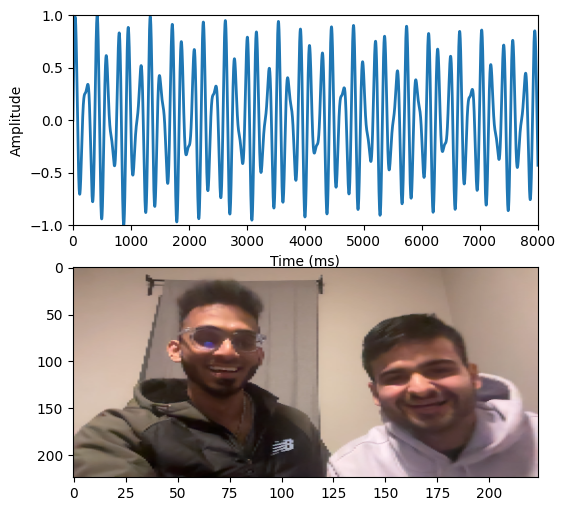

1/1 [==============================] - 0s 22ms/step
1
instrument_index is 2


In [1]:
import os
import cv2
import pyaudio
import numpy as np
from tensorflow.keras.models import load_model
import tkinter as tk
from tkinter import Canvas
from queue import Queue, Empty
import threading
from scipy import signal

import librosa
import pretty_midi
import numpy as np
import cv2

import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
from queue import Queue, Empty
import numpy as np
from matplotlib import animation

# Load instrument sounds
instruments = [pretty_midi.Instrument(program=1),  # Acoustic Grand Piano
               pretty_midi.Instrument(program=25),  # Guitar
               pretty_midi.Instrument(program=74)]  # Flute


# Load the trained model
try:
    model = load_model('hand_gesture_model.keras')
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

def generate_wave(frequency, volume, duration, sample_rate, wave_type):
    if wave_type == 0:
        return generate_sine_wave(frequency, volume, duration, sample_rate)
    elif wave_type == 1:
        return generate_square_wave(frequency, volume, duration, sample_rate)
    elif wave_type == 2:
        return generate_triangle_wave(frequency, volume, duration, sample_rate)

import librosa

def play_instrument_sound(instrument, frequency, volume, duration, sample_rate, pitch_shift=0):
    midi_note = pretty_midi.hz_to_note_number(frequency)
    note = pretty_midi.Note(velocity=int(volume * 127), pitch=midi_note, start=0, end=duration)
    instrument.notes.append(note)

    midi = pretty_midi.PrettyMIDI()
    midi.instruments.append(instrument)
    audio_wave = midi.synthesize(fs=sample_rate)

    # Apply pitch shifting
    if pitch_shift != 0:
        audio_wave = librosa.effects.pitch_shift(audio_wave, sr=sample_rate, n_steps=pitch_shift)

    return audio_wave

def generate_sine_wave(frequency, volume, duration, sample_rate):
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    return volume * np.sin(2 * np.pi * frequency * t)

def generate_square_wave(frequency, volume, duration, sample_rate):
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    square_wave = volume * signal.square(2 * np.pi * frequency * t)
    return square_wave

def generate_triangle_wave(frequency, volume, duration, sample_rate):
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    triangle_wave = volume * signal.sawtooth(2 * np.pi * frequency * t, 0.5)
    return triangle_wave


def play_sound(wave, sample_rate):
    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paFloat32, channels=1, rate=sample_rate, output=True)
    stream.write(wave.astype(np.float32).tobytes())
    stream.stop_stream()
    stream.close()
    p.terminate()

def change_pitch(frequency, change):
    return max(0, frequency + change)

def preprocess_frame(frame):
    frame = cv2.resize(frame, (224, 224))
    frame = frame / 255.0
    frame = np.expand_dims(frame, axis=0)
    return frame

def predict_gesture(model, frame):
    processed_frame = preprocess_frame(frame)
    prediction = model.predict(processed_frame)
    gesture = np.argmax(prediction, axis=1)[0]
    return gesture

def modify_audio(gesture, frequency, volume, wave_type, instrument_index):
    pitch_shift = 0
    if gesture == 1:
        volume = min(volume + 0.1, 1.0)
    elif gesture == 2:
        volume = max(volume - 0.1, 0.0)
    elif gesture == 3:
        pitch_shift = 1
        frequency = change_pitch(frequency, 50)
    elif gesture == 4:
        pitch_shift = 1
        frequency = change_pitch(frequency, -50)
    elif gesture == 5:
        wave_type = (wave_type + 1) % 3
    elif gesture == 6:
        wave_type = 4
        instrument_index = (instrument_index + 1) % len(instruments)
    return frequency, volume, wave_type, instrument_index, pitch_shift


def create_gui(queue):
    root = tk.Tk()
    root.title("Sound Wave and Frame Display")

    # Set up the matplotlib figure and axes for the wave
    fig, (ax_wave, ax_frame) = plt.subplots(2, figsize=(6, 6))
    line, = ax_wave.plot([], [], lw=2)
    ax_wave.set_ylim(-1, 1)
    ax_wave.set_xlim(0, 8000)
    ax_wave.set_ylabel('Amplitude')
    ax_wave.set_xlabel('Time (ms)')

    im_display = ax_frame.imshow(np.zeros((224, 224, 3)), aspect='auto')

    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

    pitch_label = tk.Label(root, text="Pitch: ")
    pitch_label.pack()
    amplitude_label = tk.Label(root, text="Amplitude: ")
    amplitude_label.pack()

    def init():
        line.set_data([], [])
        return line, im_display

    def update(frame):
        try:
            wave, pitch, amplitude, frame_image = queue.get_nowait()
            line.set_data(np.arange(len(wave)), wave)
            im_display.set_data(frame_image)
            pitch_label.config(text=f"Pitch: {pitch:.2f} Hz")
            amplitude_label.config(text=f"Amplitude: {amplitude:.2f}")
        except Empty:
            pass
        return line, im_display

    ani = animation.FuncAnimation(fig, update, init_func=init, blit=True, interval=50)
    
    root.mainloop()
    return root


def capture_and_display(queue):
    try:
        cap = cv2.VideoCapture(1)
    except Exception as e:
        print(f"Error accessing camera: {e}")
        exit()

    frequency = 440
    volume = 0.5
    duration = 3
    sample_rate = 44100

    wave_type = 0
    instrument_index = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        gesture = predict_gesture(model, frame)
        print(gesture)
        pitch_shift = 0
        frequency, volume, wave_type, instrument_index, pitch_shift = modify_audio(gesture, frequency, volume, wave_type, instrument_index)

        if wave_type < 3:
            # Generate the wave based on the wave_type
            wave = generate_wave(frequency, volume, duration, sample_rate, wave_type)
        else:
            # Play the instrument sound
            print("instrument_index is", instrument_index)
            wave = play_instrument_sound(instruments[instrument_index], frequency, volume, duration, sample_rate, pitch_shift)

        play_sound(wave, sample_rate)

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_rgb = cv2.resize(frame_rgb, (224, 224))
        queue.put((wave, frequency, volume, frame_rgb))

        if cv2.waitKey(10) == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


data_queue = Queue()
capture_display_thread = threading.Thread(target=capture_and_display, args=(data_queue,), daemon=True)
capture_display_thread.start()
print("Starting GUI...")
create_gui(data_queue)